# Toy example

In [189]:
using Random
rand_state = 42
Random.seed!(rand_state)

MersenneTwister(42)

To check that everything is working well, we will replicate an example from Murphy (2022). The Python code generating the example has been [open sourced](https://github.com/probml/pyprobml/blob/master/scripts/logreg_laplace_demo.py). The author of the code uses the `bayes_logistic` function to run Bayesian Logistic Regression (BLR) using Laplace approximation (source code available [here](https://bayes-logistic.readthedocs.io/en/latest/_modules/bayes_logistic/bayes_logistic.html#fit_bayes_logistic)). Here we will code up BLR from scratch in Julia programming language. First, let's generate the synthetic dataset used for the example in Murphy (2022).

In [190]:
using CSV
using DataFrames
df = CSV.read("./data/toy_data.csv", DataFrame);
select(df, :y => (x -> map(x -> Int(x), x)) => :y);

For visualization purposes I prefer working with R's `ggplot2`. Fortunately, Julia makes it incredibly easy to work with R packages.

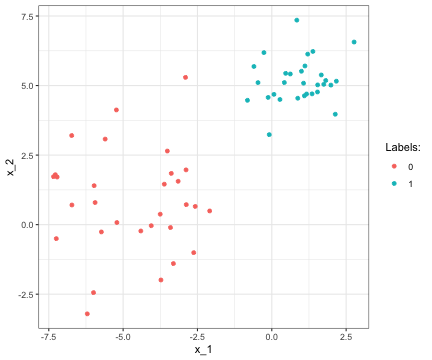

RObject{VecSxp}


In [191]:
# Loading library
using RCall
@rlibrary ggplot2
p = ggplot() +
    geom_point(data=df, aes(x=:x_1, y=:x_2, color=R"factor($df$y)")) +
    scale_color_discrete(name="Labels:") +
    theme_bw()

In [192]:
using LinearAlgebra
include("julia/bayes_logreg.jl");

In [193]:
y = df[:,:y]
X = Matrix(df[:,Not(:y)])
d = size(X)[2] # number of features
σ = 10 # noise
w_0 = zeros(d)
H_0 = UniformScaling(1/(σ^2));

In [194]:
T = 10000
sgd_options = (
    ρ_0=1.0,
    T=T,
    ε=0.1/T
)
mod = bayes_logreg(X,y,w_0,H_0,sgd_options...);
w_map = μ(mod)

2-element Vector{Float64}:
 2.0031970557927945
 0.8672471332804566

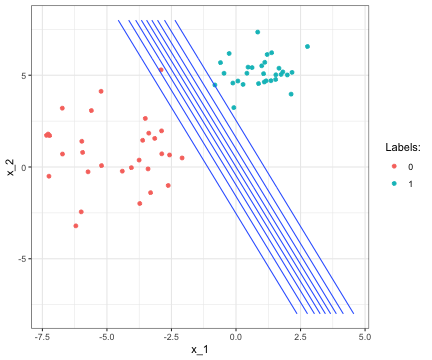

RObject{VecSxp}


In [195]:
y_grid_map = sigmoid(w_map, X_grid) # plugin predictive
df_grid = DataFrame(hcat(y_grid_map,X_grid), :auto)
p + stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1)) 

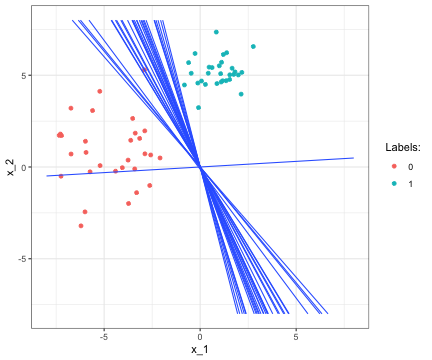

RObject{VecSxp}


In [196]:
p_sample = p
n_sample = 30
W = sample_posterior(mod,n_sample)
for i = 1:size(W)[2]
    w_sample = W[:,i]
    y_grid_sample = sigmoid(w_sample, X_grid) # sample predictive
    df_grid = DataFrame(hcat(y_grid_sample,X_grid), :auto)
    p_sample += stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1), bins=2);
end
p_sample

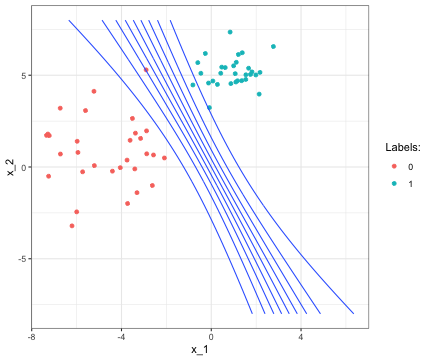

RObject{VecSxp}


In [197]:
y_mc = 1/n_sample .* sigmoid(W, X_grid) * ones(n_sample)
df_grid = DataFrame(hcat(y_mc,X_grid), :auto)
p + stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1)) 

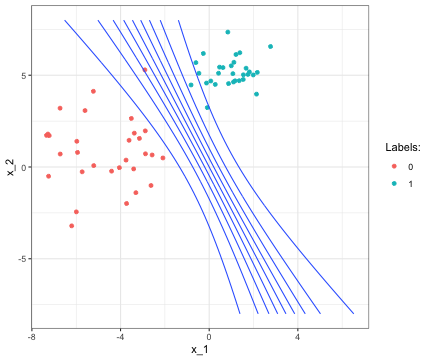

RObject{VecSxp}


In [198]:
y_probit = posterior_predictive(mod, X_grid) 
df_grid = DataFrame(hcat(y_probit,X_grid), :auto)
p + stat_contour(data=df_grid, aes(x = :x2, y = :x3, z = :x1)) 